### Target:

- Reduce the number of parameters in the model

### Results:

- Parameters: 13.7K
- Best Training Accuracy: 97.34
- Best Test Accuracy: 98.58

### Analysis:

- The model performed terribly after reducing the number of parameters
- Hence, the architecture was modified by shifting a layer from block 2 to block1
- The receptive field of the model is increased to 30
- The model still has potential since the test accuracy is better than the training accuracy

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

Here is the list of all the transformations which come pre-built with PyTorch

1.   Compose
2.   ToTensor
3.   ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.Normalize((0.1325,), (0.3104,))
    ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 111979700.56it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 129418476.31it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 25184045.23it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 1147829.65it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 8

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8170)
 - mean: tensor(-0.0110)
 - std: tensor(0.8580)
 - var: tensor(0.7361)
torch.Size([512, 1, 28, 28])
torch.Size([512])


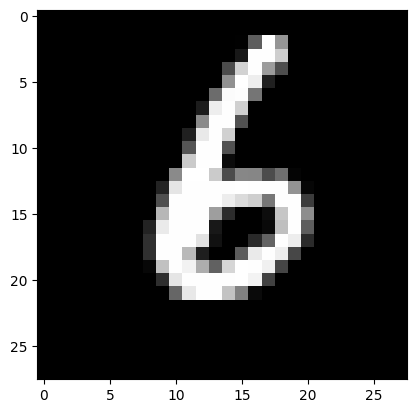

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray')


# Augmentation Visualization

origingal


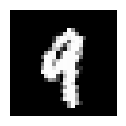

 
centercrop


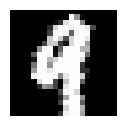

 
resize


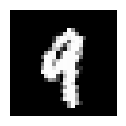

 
rotation


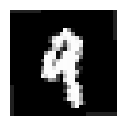

 
normalize


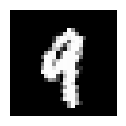

In [ ]:
import numpy as np

def plot(imgs, title=None):
    figure = plt.figure(figsize=(5,5))
    num_of_images = len(imgs)
    for index in range(0, num_of_images):
        plt.subplot(4,3,index+1)
        plt.axis('off')
        if title:
            plt.title=title
        plt.imshow(imgs[index].numpy().squeeze(), cmap='gray')
        plt.tight_layout()
        plt.xticks([])
        plt.yticks([])
        plt.show()

batch = next(iter(train_loader))
imgs, labels = batch[0], batch[1]
orig_img, label = imgs[0], labels[0]
orig_img = orig_img.unsqueeze(0)

transformations = {
    'centercrop': transforms.RandomApply([transforms.CenterCrop(20), ], p=1.0),
    'resize': transforms.Resize((28, 28)),
    'rotation': transforms.RandomRotation((-15., 15.), fill=0),
    'normalize': transforms.Normalize((0.1307,), (0.3081,)),
}

print("original")
plot(orig_img)

for key, trans in transformations.items():
    print(" ")
    print(key)
    out = trans(orig_img)
    plot(out)

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

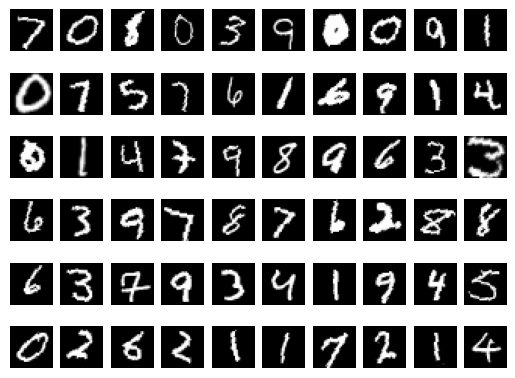

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

# The model
- Let's start with the expand and squeeze model architecture
- The number of channels in a block will keep on increasing. In the transition block, the number of channels will be reduced

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 3, padding=0, bias=False)       # 28 > 26 | 3
        self.conv2 = nn.Conv2d(12, 16, 3, padding=0, bias=False)      # 26 > 24 | 5
        self.conv3 = nn.Conv2d(16, 18, 3, padding=0, bias=False)      # 24 > 22 | 7
        self.conv4 = nn.Conv2d(18, 12, 3, padding=0, bias=False)      # 22 > 20 | 9

        self.pool1 = nn.MaxPool2d(2, 2)                               # 20 > 10 | 10

        self.conv5 = nn.Conv2d(12, 16, 3, padding=0, bias=False)      # 10 > 8 | 14
        self.conv6 = nn.Conv2d(16, 18, 3, padding=0, bias=False)      #  8 > 6 | 18

        self.conv7 = nn.Conv2d(18, 12, 3, padding=0, bias=False)     # 6 > 4 | 22
        self.conv8 = nn.Conv2d(12, 12, 3, padding=0, bias=False)     # 4 > 2 | 26
        self.conv9 = nn.Conv2d(12, 10, 2, padding=0, bias=False)     # 2 > 1 | 30

    def forward(self, x):
        x = self.conv4(F.relu(self.conv3(F.relu(self.conv2(F.relu(self.conv1(x)))))))
        x = self.pool1(x)
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv9(self.conv8(F.relu(self.conv7(x))))
        x = x.view(-1, 10)                                             # 1x1x10 > 10
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 12, 26, 26]             108
            Conv2d-2           [-1, 16, 24, 24]           1,728
            Conv2d-3           [-1, 18, 22, 22]           2,592
            Conv2d-4           [-1, 12, 20, 20]           1,944
         MaxPool2d-5           [-1, 12, 10, 10]               0
            Conv2d-6             [-1, 16, 8, 8]           1,728
            Conv2d-7             [-1, 18, 6, 6]           2,592
            Conv2d-8             [-1, 12, 4, 4]           1,944
            Conv2d-9             [-1, 12, 2, 2]           1,296
           Conv2d-10             [-1, 10, 1, 1]             480
Total params: 14,412
Trainable params: 14,412
Non-trainable params: 0
---------------------------------------------------------

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=2.3023107051849365 Batch_id=117 Accuracy=12.75: 100%|██████████| 118/118 [00:48<00:00,  2.44it/s]



Test set: Average loss: 2.3023, Accuracy: 1387/10000 (13.87%)

EPOCH: 1


Loss=2.3008368015289307 Batch_id=117 Accuracy=13.83: 100%|██████████| 118/118 [00:40<00:00,  2.93it/s]



Test set: Average loss: 2.3009, Accuracy: 1528/10000 (15.28%)

EPOCH: 2


Loss=0.9104827046394348 Batch_id=117 Accuracy=26.89: 100%|██████████| 118/118 [00:41<00:00,  2.81it/s]



Test set: Average loss: 0.8724, Accuracy: 7263/10000 (72.63%)

EPOCH: 3


Loss=0.4348061978816986 Batch_id=117 Accuracy=82.25: 100%|██████████| 118/118 [00:41<00:00,  2.87it/s]



Test set: Average loss: 0.3150, Accuracy: 9077/10000 (90.77%)

EPOCH: 4


Loss=0.33428871631622314 Batch_id=117 Accuracy=90.08: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]



Test set: Average loss: 0.1759, Accuracy: 9468/10000 (94.68%)

EPOCH: 5


Loss=0.25821995735168457 Batch_id=117 Accuracy=93.10: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]



Test set: Average loss: 0.1552, Accuracy: 9531/10000 (95.31%)

EPOCH: 6


Loss=0.08466546982526779 Batch_id=117 Accuracy=94.61: 100%|██████████| 118/118 [00:40<00:00,  2.88it/s]



Test set: Average loss: 0.0952, Accuracy: 9691/10000 (96.91%)

EPOCH: 7


Loss=0.1960197240114212 Batch_id=117 Accuracy=95.66: 100%|██████████| 118/118 [00:40<00:00,  2.92it/s]



Test set: Average loss: 0.0883, Accuracy: 9708/10000 (97.08%)

EPOCH: 8


Loss=0.05002102628350258 Batch_id=117 Accuracy=95.96: 100%|██████████| 118/118 [00:42<00:00,  2.76it/s]



Test set: Average loss: 0.0679, Accuracy: 9797/10000 (97.97%)

EPOCH: 9


Loss=0.0766531303524971 Batch_id=117 Accuracy=96.39: 100%|██████████| 118/118 [00:41<00:00,  2.83it/s]



Test set: Average loss: 0.0691, Accuracy: 9787/10000 (97.87%)

EPOCH: 10


Loss=0.06012473627924919 Batch_id=117 Accuracy=96.74: 100%|██████████| 118/118 [00:40<00:00,  2.89it/s]



Test set: Average loss: 0.0714, Accuracy: 9767/10000 (97.67%)

EPOCH: 11


Loss=0.13012778759002686 Batch_id=117 Accuracy=96.92: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]



Test set: Average loss: 0.0672, Accuracy: 9786/10000 (97.86%)

EPOCH: 12


Loss=0.0782657265663147 Batch_id=117 Accuracy=97.06: 100%|██████████| 118/118 [00:40<00:00,  2.90it/s]



Test set: Average loss: 0.0581, Accuracy: 9812/10000 (98.12%)

EPOCH: 13


Loss=0.17763131856918335 Batch_id=117 Accuracy=97.25: 100%|██████████| 118/118 [00:43<00:00,  2.74it/s]



Test set: Average loss: 0.0562, Accuracy: 9823/10000 (98.23%)

EPOCH: 14


Loss=0.04396362975239754 Batch_id=117 Accuracy=97.34: 100%|██████████| 118/118 [00:45<00:00,  2.62it/s]



Test set: Average loss: 0.0438, Accuracy: 9858/10000 (98.58%)



# Visualize Losses and Accuracies

In [ ]:
# train_losses

In [ ]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

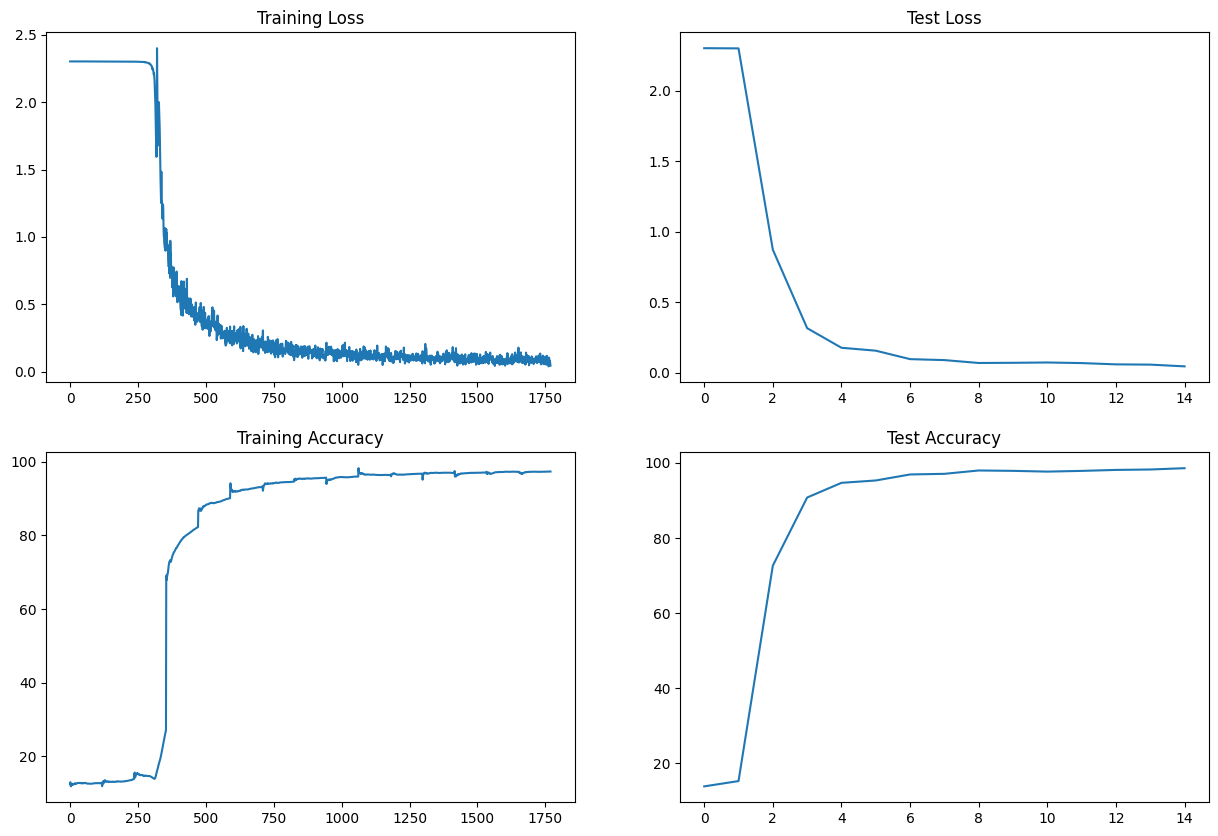

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")